# Chosen Dataset

I have chosen to work on a Meat Quality Assesment Dataset.

[https://www.kaggle.com/datasets/crowww/meat-quality-assessment-based-on-deep-learning/data]

# Importing necessary packages + Mounting Google Drive

In [1]:
# Standard Library Imports
import os
import shutil
import random

# Third-Party Library Imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve

# TensorFlow and Keras Imports
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import (MobileNetV2, InceptionV3, ResNet50, VGG16, EfficientNetB0)
from tensorflow.keras.callbacks import EarlyStopping

# PIL (Python Imaging Library)
from PIL import ImageFile

# Matplotlib Formatting Tools
from matplotlib.ticker import MaxNLocator

# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Solutioning Part 1

## Data Preprocessing

### Unzipping dataset

In [ ]:
destinationFolder = '/content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset'
filename = '/content/drive/MyDrive/Colab Notebooks/DLOR/Project/Meat Quality Dataset.zip'

In [ ]:
!unzip "$filename" -d "$destinationFolder"

Archive:  /content/drive/MyDrive/Colab Notebooks/DLOR/Project/Meat Quality Dataset.zip
  inflating: /content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/Fresh/test_20171016_104321D.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/Fresh/test_20171016_104521D.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/Fresh/test_20171016_104721D.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/Fresh/test_20171016_104921D.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/Fresh/test_20171016_105121D.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/Fresh/test_20171016_105321D.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/Fresh/test_20171016_105521D.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/Fresh/test_20171016_105721D.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/DLOR/

### Splitting into Training, Validation and Testing sets

In [ ]:
def create_folder(path):  # Create folder(s) if it doesn't exist
    try:
        os.mkdir(path)
    except FileExistsError:
        print("The folder already exists:", path)
    else:
        print("The folder is created:", path)

In [ ]:
# The path where the original dataset is stored, organized by class.
source_folder = '/content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset'

# Define the folder paths for the dataset splits
training_folder = '/content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/training_set'
validation_folder = '/content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/validation_set'
testing_folder = '/content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/testing_set'

# Create the folders for dataset splits
create_folder(training_folder)
create_folder(validation_folder)
create_folder(testing_folder)

# Define the class labels
classes = ['Fresh', 'Spoiled']

# Create subfolders for each class within each dataset split
for folder in [training_folder, validation_folder, testing_folder]:
    create_folder(folder)
    for class_name in classes:
        create_folder(os.path.join(folder, class_name))

# Function to split and copy images into training, validation, and testing sets
def split_and_copy(src_dir, train_dir, val_dir, test_dir, train_size=0.7, val_size=0.2):
    images = os.listdir(src_dir)
    train_imgs, temp_imgs = train_test_split(images, test_size=(1 - train_size), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(1 - val_size / (1 - train_size)), random_state=42)

    # Copy images to respective folders
    for img in train_imgs:
        shutil.copy(os.path.join(src_dir, img), os.path.join(train_dir, img))
    for img in val_imgs:
        shutil.copy(os.path.join(src_dir, img), os.path.join(val_dir, img))
    for img in test_imgs:
        shutil.copy(os.path.join(src_dir, img), os.path.join(test_dir, img))

The folder is created: /content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/training_set
The folder is created: /content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/validation_set
The folder is created: /content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/testing_set
The folder already exists: /content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/training_set
The folder is created: /content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/training_set/Fresh
The folder is created: /content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/training_set/Spoiled
The folder already exists: /content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/validation_set
The folder is created: /content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/validation_set/Fresh
The folder is created: /content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/validation_set/Spoiled
The folder already exists: /content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/testin

In [ ]:
# Loop through each class to split and copy images
for class_name in classes:
    src_dir = os.path.join(source_folder, class_name)
    train_dir = os.path.join(training_folder, class_name)
    val_dir = os.path.join(validation_folder, class_name)
    test_dir = os.path.join(testing_folder, class_name)

    split_and_copy(src_dir, train_dir, val_dir, test_dir)

# Verify the image counts in each folder
for folder in [training_folder, validation_folder, testing_folder]:
    for class_name in classes:
        path = os.path.join(folder, class_name)
        print(f"{path}: {len(os.listdir(path))} images")

/content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/training_set/Fresh: 663 images
/content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/training_set/Spoiled: 663 images
/content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/validation_set/Fresh: 189 images
/content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/validation_set/Spoiled: 189 images
/content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/testing_set/Fresh: 96 images
/content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/testing_set/Spoiled: 96 images


## Data Exploration

In [118]:
train_path = '/content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/training_set'
validation_path = '/content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/validation_set'
test_path = '/content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/testing_set'

### Check class distribution across the 3 different sets

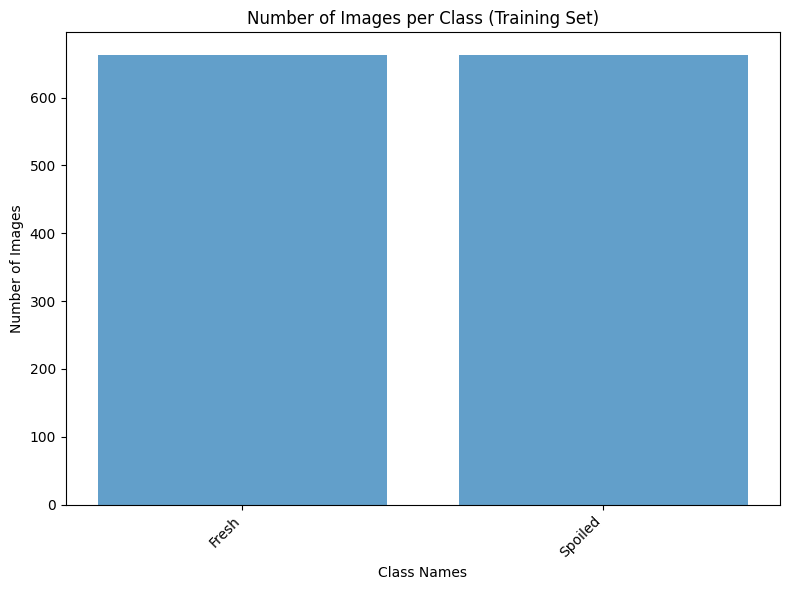

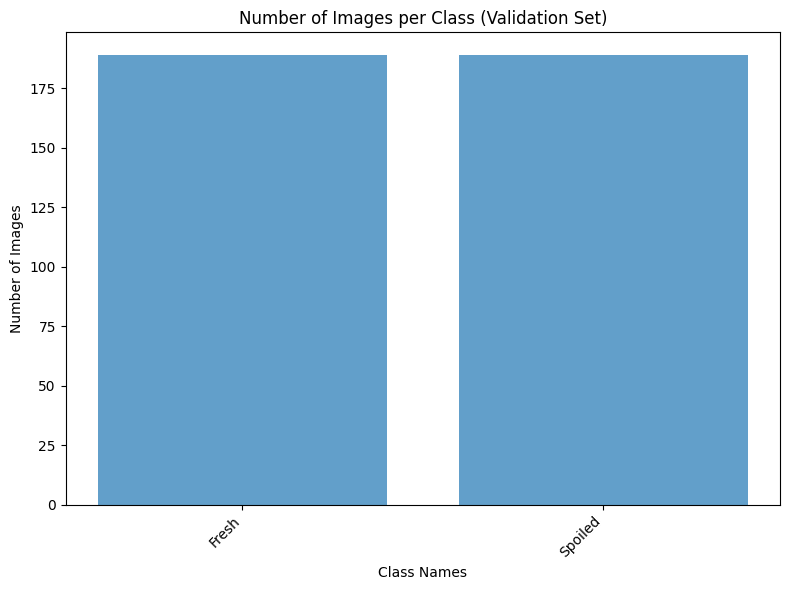

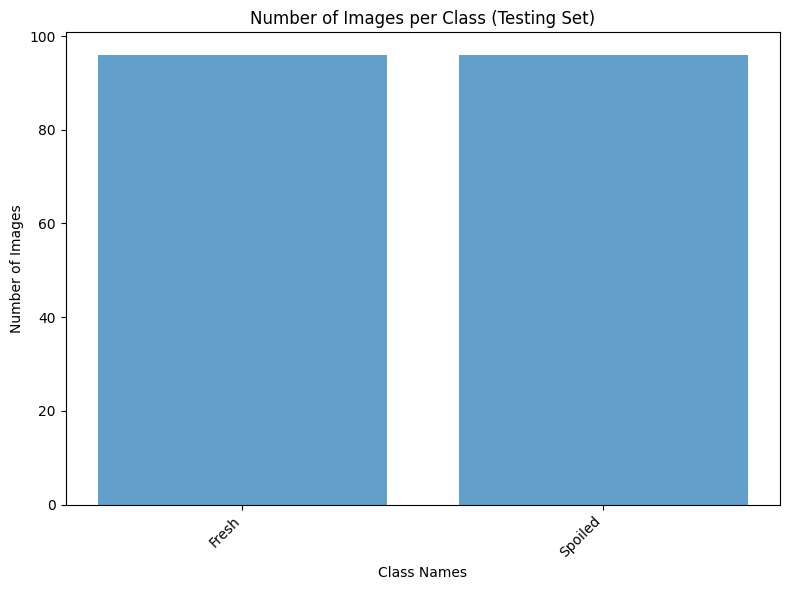

In [119]:
# Define subsets and their paths correctly
subsets = {
    "Training Set": train_path,
    "Validation Set": validation_path,
    "Testing Set": test_path,
}

# Iterate through each subset and count images for each class
for subset_name, subset_path in subsets.items():
    class_counts = {}

    # Count files in each class subfolder
    for class_name in os.listdir(subset_path):
        class_path = os.path.join(subset_path, class_name)
        if os.path.isdir(class_path):
            file_count = len(os.listdir(class_path))  # Count files in the class subfolder
            class_counts[class_name] = file_count

    # Plot the class distribution for the current subset
    plt.figure(figsize=(8, 6))
    bars = plt.bar(class_counts.keys(), class_counts.values(), alpha=0.7)
    plt.title(f"Number of Images per Class ({subset_name})")
    plt.xlabel("Class Names")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

The 2 classes are balanced across all 3 datasets.

### Analyze sample images and dimensions

Fresh Meat - Train:


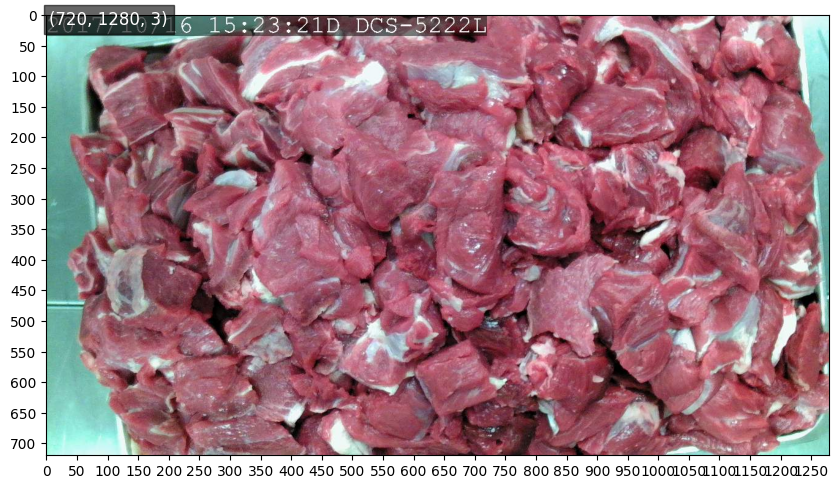


Spoiled Meat - Train:


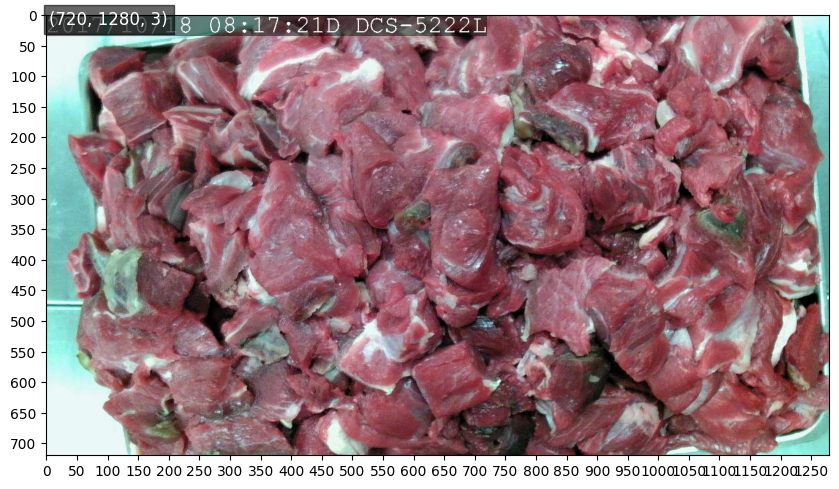

In [120]:
# Function to visualize images and check for dimensions
def visualize_images_with_axes(folder_path, num_images=1):
    images = random.sample(os.listdir(folder_path), num_images)  # Randomly select images

    plt.figure(figsize=(15, 5))

    for i, img_name in enumerate(images):
        img_path = os.path.join(folder_path, img_name)
        sample_image = load_img(img_path)
        img_array = img_to_array(sample_image)  # Convert the image to NumPy array

        # Display the image in a subplot
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(sample_image)

        plt.xticks(np.arange(0, sample_image.width, step=50))
        plt.yticks(np.arange(0, sample_image.height, step=50))
        plt.grid(False)

        ax.text(5, 15, f"{img_array.shape}", fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.6))

    plt.tight_layout()
    plt.show()

#  Visualize and check dimensions for 'Fresh' class images in the training set
print("Fresh Meat - Train:")
visualize_images_with_axes('/content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/training_set/Fresh')

print()

# Visualize and check dimensions for 'Spoiled' class images in the training set
print("Spoiled Meat - Train:")
visualize_images_with_axes('/content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/training_set/Spoiled')

All images in the dataset have standardised dimensions of (720, 1280, 3).

## Data Augmentation


In [146]:
# Create a data generator for training with augmentation
datagen_train = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values to the range [0,1]
    rotation_range=5,             # Randomly rotate images by up to 5 degrees
    width_shift_range=0.1,        # Randomly shift images horizontally by up to 10% of the width
    height_shift_range=0.1,       # Randomly shift images vertically by up to 10% of the height
    zoom_range=0.1,               # Randomly zoom in or out by up to 10%
    horizontal_flip=True,         # Randomly flip images horizontally
    brightness_range=[0.8, 1.2],  # Adjust brightness within the specified range
    shear_range=0.1,              # Apply shear transformations up to 10% to tilt images
    channel_shift_range=0.1,      # Randomly shift colors in the image channels
    fill_mode='nearest'           # Fill missing pixels after transformations with the nearest valid pixel
)

# No augmentation need for validation and test data; only normalize them
datagen_valid = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

In [147]:
# Prevent loading issues with truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Create generators for train, validation, and test sets
train_generator = datagen_train.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

validation_generator = datagen_valid.flow_from_directory(
    validation_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

test_generator = datagen_test.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

Found 1326 images belonging to 2 classes.
Found 378 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


### Visualize sample images after Data Augmentation

In [148]:
# Get class names from the train generator
classes_dict = dict(train_generator.class_indices)

# Reverse the dictionary to map numerical labels back to class names
classes_dict = {v: k for k, v in classes_dict.items()}

# Fetch a batch of images and labels from the train generator
images, labels = next(train_generator)

# Plot the images along with their class names
plt.figure(figsize=(20, 20))
for i in range(20):  # Plot first 25 images in the batch
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])

    # Decode the label from one-hot encoding to class name
    class_idx = labels[i].argmax()        # Find the index of the class with the highest probability
    class_name = classes_dict[class_idx]  # Map index to the corresponding class name
    plt.title(class_name)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Creating CNN Model

In [149]:
# Images are resized to 224x224 with 3 color channels (RGB)
input_shape = (224, 224, 3)

# Initialize the Sequential model
model = tf.keras.Sequential()

# First CONV => RELU => POOL
model.add(tf.keras.layers.Conv2D(6, kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    input_shape=input_shape,
    kernel_regularizer=tf.keras.regularizers.l2(0.01),  # L2 Regularization
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros'
))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Second CONV => RELU => POOL
model.add(tf.keras.layers.Conv2D(16, kernel_size=(5, 5),
    padding='valid',
    kernel_regularizer=tf.keras.regularizers.l2(0.01)  # L2 Regularization
))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Third CONV => RELU
model.add(tf.keras.layers.Conv2D(120, kernel_size=(5, 5),
    padding='valid',
    kernel_regularizer=tf.keras.regularizers.l2(0.01)  # L2 Regularization
))
model.add(tf.keras.layers.Activation('relu'))

# Flatten the feature maps
model.add(tf.keras.layers.Flatten())

# Fully Connected Layer
model.add(tf.keras.layers.Dense(84,
    kernel_regularizer=tf.keras.regularizers.l2(0.01)  # L2 Regularization
))
model.add(tf.keras.layers.Dropout(0.5))  # Dropout Layer

# Output Layer for Categorical Classification
model.add(tf.keras.layers.Dense(2, activation='softmax',
    kernel_regularizer=tf.keras.regularizers.l2(0.01)  # L2 Regularization
))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [150]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_43 (Conv2D)                   │ (None, 224, 224, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_43 (Activation)           │ (None, 224, 224, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 112, 112, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 108, 108, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_44 (Activation)           │ (None, 108, 108, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 50, 50, 120)         │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_45 (Activation)           │ (None, 50, 50, 120)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 300000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 84)                  │      25,200,084 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 2)                   │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,251,246 (96.33 MB)

 Trainable params: 25,251,246 (96.33 MB)

 Non-trainable params: 0 (0.00 B)

### Early stopping

In [151]:
# Early Stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

### Training the model

In [152]:
model_log = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch = len(train_generator),
    validation_steps = len(validation_generator),
    callbacks=[early_stop],
    epochs=30
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 36s 811ms/step - accuracy: 0.5556 - loss: 2.4474 - val_accuracy: 0.9339 - val_loss: 1.2344
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 786ms/step - accuracy: 0.8615 - loss: 1.2107 - val_accuracy: 0.9841 - val_loss: 0.8503
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 784ms/step - accuracy: 0.9616 - loss: 0.8288 - val_accuracy: 0.8757 - val_loss: 0.8239
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 786ms/step - accuracy: 0.9233 - loss: 0.7384 - val_accuracy: 0.9841 - val_loss: 0.6168
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 789ms/step - accuracy: 0.9543 - loss: 0.6219 - val_accuracy: 0.9894 - val_loss: 0.5547
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 784ms/step - accuracy: 0.9480 - loss: 0.5912 - val_accuracy: 0.9180 - val_loss: 0.5594
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 793ms/step - accuracy: 0.9428 - loss: 0.5433 - val_accuracy: 0.9021 - val_loss: 0.5923
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 783ms/step - accuracy: 0.9362 - loss: 0.5404 - val_accu

## Model Evaluation

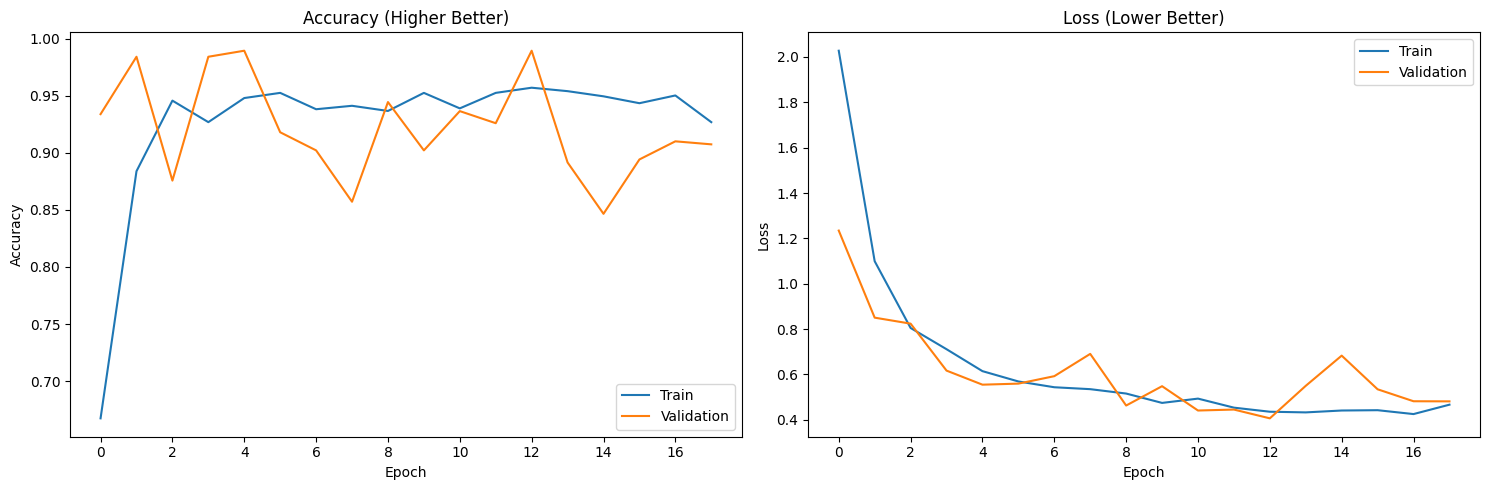

In [153]:
# Plot training and validation metrics
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy Plot
ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher Better)')
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(['Train', 'Validation'], loc='lower right')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# Loss Plot
ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower Better)')
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(['Train', 'Validation'], loc='upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

**Accuracy Chart (Left)**

Observation:
- The training accuracy increases steadily, while the validation accuracy fluctuates but still shows signs of improvement.
- Validation accuracy is slightly lower than training accuracy, suggesting that the model performs better on the training set.
---
Analysis:
- The gap between the training and validation accuracy indicates potential overfitting, as the model performs better on the training data.
- The fluctuations in validation accuracy suggest that the model is struggling to generalize consistently across all validation samples.

**Loss Chart (Right)**

Observation:
- Both training and validation losses decrease rapidly in the early epochs.
- However, the validation loss remains slightly higher than the training loss as the training progresses.
---
Analysis:

The small gap between training and validation loss suggests that the model is not overfitting excessively.

In [154]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(validation_generator, steps=int(validation_generator.samples / validation_generator.batch_size))
print(f"Validation Accuracy: {val_acc:.4f} \nValidation Loss: {val_loss:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - accuracy: 0.9967 - loss: 0.4109
Validation Accuracy: 0.9886 
Validation Loss: 0.4062


In [155]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator, steps=int(test_generator.samples / test_generator.batch_size))
print(f"Test Accuracy: {test_acc:.4f} \nTest Loss: {test_loss:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - accuracy: 0.9863 - loss: 0.3795
Test Accuracy: 0.9792 
Test Loss: 0.3849


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step


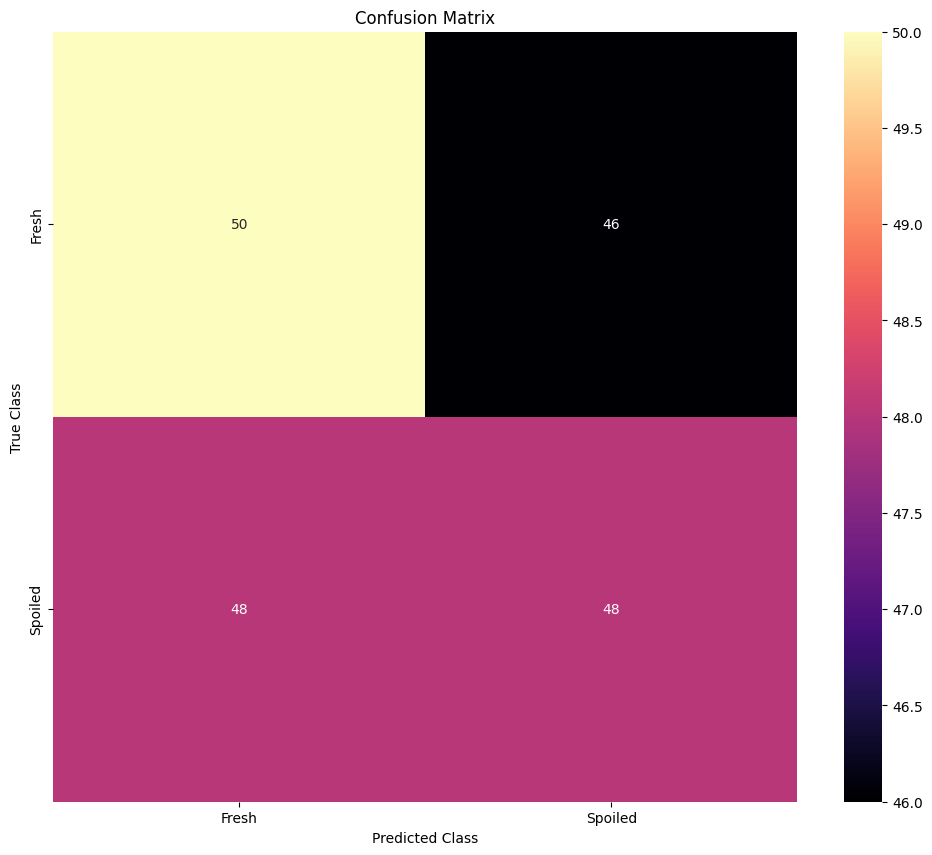

In [156]:
# Get class names from the data generator
class_names = list(validation_generator.class_indices.keys())

# True labels from the test generator
true_labels = test_generator.classes

# Model predictions for the test data
pred_probs = model.predict(test_generator, steps=int(test_generator.samples / test_generator.batch_size))
pred_labels = np.argmax(pred_probs, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="magma", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

**Observations from the Matrix**

The model correctly classified:
- 50 "Fresh" samples as "Fresh."
- 48 "Spoiled" samples as "Spoiled."
---
The model misclassified:
- 46 "Fresh" samples as "Spoiled" (False Positives for "Spoiled").
- 48 "Spoiled" samples as "Fresh" (False Negatives for "Spoiled").

In [157]:
# Classification Report
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=class_names))


Classification Report:

              precision    recall  f1-score   support

       Fresh       0.51      0.52      0.52        96
     Spoiled       0.51      0.50      0.51        96

    accuracy                           0.51       192
   macro avg       0.51      0.51      0.51       192
weighted avg       0.51      0.51      0.51       192



## Plans for Improvement

**Overall**

Although the model achieved an overall test accuracy of 97.9%, the confusion matrix and classification report revealed that it struggles to classify both classes effectively. This indicates overfitting and poor generalization.

---
**Suggested Improvement**

In part 2, I plan on improving my model performance by doing:
1. Transfer Learning with Pre-Trained Models:
- Utilize pre-trained models, as they can extract more complex features such as edges, textures, and shapes.
- These features are particularly critical for meat quality analysis tasks, where subtle details like texture, marbling, and patterns play a significant role in classification.

2. Hyperparameter Tuning:

- Explore and fine-tune learning rates to find the optimal setting for better convergence.

3. Regularization:

- Experiment with varying dropout rates and L2 regularization values to address the issue of overfitting.


---

**Conclusion**

The current baseline model, due to its limited architecture, lacks the capacity to learn these complex features effectively. Its simplicity resulted in a failure to capture the finer details necessary to accurately classify between "Fresh" and "Spoiled" meat.


# Solutioning Part 2

## Define Directories

In [2]:
train_path = '/content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/training_set'
validation_path = '/content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/validation_set'
test_path = '/content/drive/MyDrive/Colab Notebooks/DLOR/Project/Dataset/testing_set'

## Define Constants

In [3]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
CLASS_MODE='categorical'
EPOCHS_TRANSFER = 25
EPOCHS_FINE_TUNE = 15
LEARNING_RATE_TRANSFER = 0.0001
LEARNING_RATE_FINE_TUNE = 5e-6

## Data Augmentation

In [4]:
# Create a data generator for training with augmentation
datagen_train = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values to the range [0,1]
    rotation_range=40,            # Randomly rotate images by up to 40 degrees
    width_shift_range=0.3,        # Randomly shift images horizontally by up to 30% of the width
    height_shift_range=0.3,       # Randomly shift images vertically by up to 30% of the height
    zoom_range=0.4,               # Randomly zoom in or out by up to 40%
    horizontal_flip=True,         # Randomly flip images horizontally
    brightness_range=[0.5, 1.5],  # Adjust brightness within the specified range
    shear_range=0.4,              # Apply shear transformations up to 40% to tilt images
    channel_shift_range=0.2,      # Randomly shift colors in the image channels
    fill_mode='nearest'           # Fill missing pixels after transformations with the nearest valid pixel
)

# No augmentation need for validation and test data; only normalize them
datagen_valid = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

## Create generators for train, validation, and test sets

In [5]:
# Prevent loading issues with images that are truncated or corrupted
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_generator = datagen_train.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE
)

validation_generator = datagen_valid.flow_from_directory(
    validation_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE
)

test_generator = datagen_test.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=False   # To maintain order for evaluation
)

Found 1326 images belonging to 2 classes.
Found 378 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


## Early stopping

In [6]:
# To prevent overfittingand unnecessary training
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=6,  # Allow training to continue for 6 more epochs after the best val_loss
    restore_best_weights=True
)

## Function for transfer learning and fine-tuning of model

### Transfer Learning

In [7]:
def train_transfer_learning(base_model_class, name):

   # Load the pre-trained model (without the top classification layers)
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze base model layers
    base_model.trainable = False

    # Custom layers
    x = GlobalAveragePooling2D()(base_model.output)   # Convert feature maps into a single vector
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(2, activation='softmax')(x)

    # Build model
    model = Model(inputs=base_model.input, outputs=output_layer)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE_TRANSFER),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Display model summary
    model.summary()

    print(f"\nStarting transfer learning training...\n")

    history_transfer = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=EPOCHS_TRANSFER,
        steps_per_epoch = len(train_generator),
        validation_steps = len(validation_generator),
        callbacks=[early_stopping]
    )

    # Save the transfer learning model
    model.save(f"{name}_transfer_model.keras")
    print(f"{name} Transfer Learning Model Saved!\n")

    return model, history_transfer

### Fine-tuning

In [8]:
def fine_tune_model(model_name):

    # Load the pre-trained transfer learning model
    model = tf.keras.models.load_model(f"{model_name}_transfer_model.keras")

    class_weights_dict = {0: 2.0, 1: 1.0}

    print("\nUnfreezing last 20 layers for fine-tuning...\n")
    # Unfreeze last 20 layers for fine-tuning
    for layer in model.layers[-20:]:
        layer.trainable = True    # Enable training for these layers

    # Recompile model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE_FINE_TUNE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"\nStarting fine-tuning training...\n")

    # Fine-tuning
    history_finetune = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=EPOCHS_FINE_TUNE,
        steps_per_epoch = len(train_generator),
        validation_steps = len(validation_generator),
        class_weight=class_weights_dict,
        callbacks=[early_stopping]
    )

    # Save the fine-tuned model
    model.save(f"{model_name}_fine_tuned_model.keras")
    print(f"{model_name} Fine-Tuned Model Saved!\n")

    return model, history_finetune

## Function to evaluate model

In [9]:
# Store performance results separately
transfer_results = {}
fine_tune_results = {}

def evaluate_model(model, history_transfer, history_finetune, name, phase="Transfer Learning"):

    print(f"\nEvaluating on validation set and test set...\n")

    # Evaluate on validation set
    val_loss, val_acc = model.evaluate(validation_generator, steps=len(validation_generator))
    print(f"Validation Accuracy: {val_acc:.4f} \nValidation Loss: {val_loss:.4f}")

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
    print(f"{name} Test Accuracy: {test_acc:.4f}\nTest Loss: {test_loss:.4f}")

    # Predictions on test set
    pred_probs = model.predict(test_generator)  # Get predicted probabilities
    pred_labels = np.argmax(pred_probs, axis=1)  # Convert probabilities to class labels
    true_labels = test_generator.classes  # Get the atual test labels

    # Ensure both arrays have the same shape
    print(f"True Labels Shape: {true_labels.shape}, Pred Labels Shape: {pred_labels.shape}")

    print(f"\nPlotting accuracy and loss metrics...\n")

    # Plot training and validation/loss metrics
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history_transfer.history['accuracy'], label='Transfer Train Accuracy')
    ax1.plot(history_transfer.history['val_accuracy'], label='Transfer Validation Accuracy')

    if history_finetune is not None:    # If fine-tuning history exists, plot additional curves
        ax1.plot(history_finetune.history['accuracy'], label='Fine-Tune Train Accuracy', linestyle='--')
        ax1.plot(history_finetune.history['val_accuracy'], label='Fine-Tune Validation Accuracy', linestyle='--')
    ax1.set_title('Accuracy (Higher Better)')
    ax1.legend(loc='lower right')

    # Loss plot
    ax2.plot(history_transfer.history['loss'], label='Transfer Train Loss')
    ax2.plot(history_transfer.history['val_loss'], label='Transfer Validation Loss')

    if history_finetune is not None:    # If fine-tuning history exists, plot additional curves
        ax2.plot(history_finetune.history['loss'], label='Fine-Tune Train Loss', linestyle='--')
        ax2.plot(history_finetune.history['val_loss'], label='Fine-Tune Validation Loss', linestyle='--')
    ax2.set_title('Loss (Lower Better)')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    print(f"\nGenerating confusion matrix...\n")

    # Confusion matrix
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, cmap="magma", fmt='d', xticklabels=['Fresh', 'Spoiled'], yticklabels=['Fresh', 'Spoiled'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - {phase} Confusion Matrix")
    plt.show()

    print(f"\nGenerating classification report...\n")

    print("\nClassification Report:\n")
    print(classification_report(true_labels, pred_labels, target_names=['Fresh', 'Spoiled']))

    # Convert classification report into a dictionary for plotting of graphs & comparison
    report = classification_report(true_labels, pred_labels, target_names=['Fresh', 'Spoiled'], output_dict=True)

    # Store metrics based on phase
    if phase == "Transfer Learning":
        transfer_results[name] = {
            'accuracy': test_acc,
            'precision': report['weighted avg']['precision'],
            'recall': report['weighted avg']['recall'],
            'f1_score': report['weighted avg']['f1-score']
        }
    else:
        fine_tune_results[name] = {
            'accuracy': test_acc,
            'precision': report['weighted avg']['precision'],
            'recall': report['weighted avg']['recall'],
            'f1_score': report['weighted avg']['f1-score']
        }

### Graph for transfer learning model performance

In [10]:
def plot_transfer_learning_performance():
    models = list(transfer_results.keys())

    # Extract performance metrics that is stored in transfer_results
    accuracy = [transfer_results[m]['accuracy'] for m in models]
    precision = [transfer_results[m]['precision'] for m in models]
    recall = [transfer_results[m]['recall'] for m in models]
    f1_score = [transfer_results[m]['f1_score'] for m in models]

    x = np.arange(len(models))  # X-axis positions
    width = 0.2

    # Create bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - 1.5 * width, accuracy, width, label='Accuracy', color='blue')
    ax.bar(x - 0.5 * width, precision, width, label='Precision', color='red')
    ax.bar(x + 0.5 * width, recall, width, label='Recall', color='green')
    ax.bar(x + 1.5 * width, f1_score, width, label='F1-Score', color='orange')

    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title("Transfer Learning Performance")
    ax.set_xticks(x)
    ax.set_xticklabels(models)    # Set model names as x-axis labels
    ax.legend()

    plt.tight_layout()
    plt.show()

### Graph for fine-tuning model performance

In [11]:
def plot_fine_tuning_performance(models):
    models = [m for m in models if m in fine_tune_results]  # Filter only evaluated models

    if not models:
        print("No fine-tuned models to display.")
        return

    # Extract performance metrics that is stored in fine_tune_results
    accuracy = [fine_tune_results[m]['accuracy'] for m in models]
    precision = [fine_tune_results[m]['precision'] for m in models]
    recall = [fine_tune_results[m]['recall'] for m in models]
    f1_score = [fine_tune_results[m]['f1_score'] for m in models]

    x = np.arange(len(models))  # X-axis positions
    width = 0.2

    # Create bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - 1.5 * width, accuracy, width, label='Accuracy', color='blue')
    ax.bar(x - 0.5 * width, precision, width, label='Precision', color='red')
    ax.bar(x + 0.5 * width, recall, width, label='Recall', color='green')
    ax.bar(x + 1.5 * width, f1_score, width, label='F1-Score', color='orange')

    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title("Fine-Tuned Model Performance")
    ax.set_xticks(x)
    ax.set_xticklabels(models)    # Set model names as x-axis labels
    ax.legend()

    plt.tight_layout()
    plt.show()

## Transfer Learning

### InceptionV3

In [12]:
# Training
inception_model, inception_history_transfer = train_transfer_learning(InceptionV3, "InceptionV3")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,074,210 (84.21 MB)

 Trainable params: 271,042 (1.03 MB)

 Non-trainable params: 21,803,168 (83.17 MB)


Starting transfer learning training...



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 880s 21s/step - accuracy: 0.5027 - loss: 4.4695 - val_accuracy: 0.5529 - val_loss: 3.8308
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 644ms/step - accuracy: 0.6162 - loss: 4.0699 - val_accuracy: 0.7169 - val_loss: 3.6742
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 641ms/step - accuracy: 0.6365 - loss: 3.9622 - val_accuracy: 0.9048 - val_loss: 3.4674
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 638ms/step - accuracy: 0.6952 - loss: 3.7797 - val_accuracy: 0.9286 - val_loss: 3.3320
Epoch 5/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 633ms/step - accuracy: 0.7146 - loss: 3.7349 - val_accuracy: 0.9233 - val_loss: 3.3070
Epoch 6/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 632ms/step - accuracy: 0.7607 - loss: 3.5938 - val_accuracy: 0.9418 - val_loss: 3.1722
Epoch 7/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 642ms/step - accuracy: 0.7324 - loss: 3.6122 - val_accuracy: 0.9180 - val_loss: 3.1131
Epoch 8/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 636ms/step - accuracy: 0.7592 - loss: 3.5276 - val_accur


Evaluating on validation set and test set...

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.9567 - loss: 2.4800
Validation Accuracy: 0.9471 
Validation Loss: 2.4901
6/6 ━━━━━━━━━━━━━━━━━━━━ 68s 14s/step - accuracy: 0.9815 - loss: 2.4155
InceptionV3 Test Accuracy: 0.9792
Test Loss: 2.4529
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step
True Labels Shape: (192,), Pred Labels Shape: (192,)

Plotting accuracy and loss metrics...



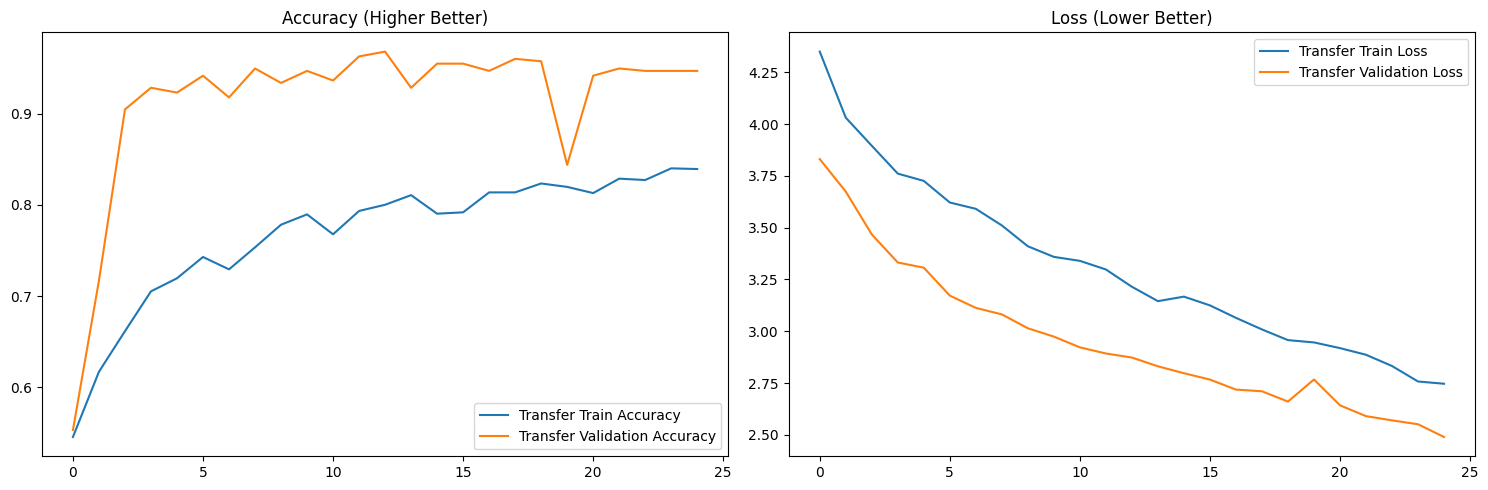


Generating confusion matrix...



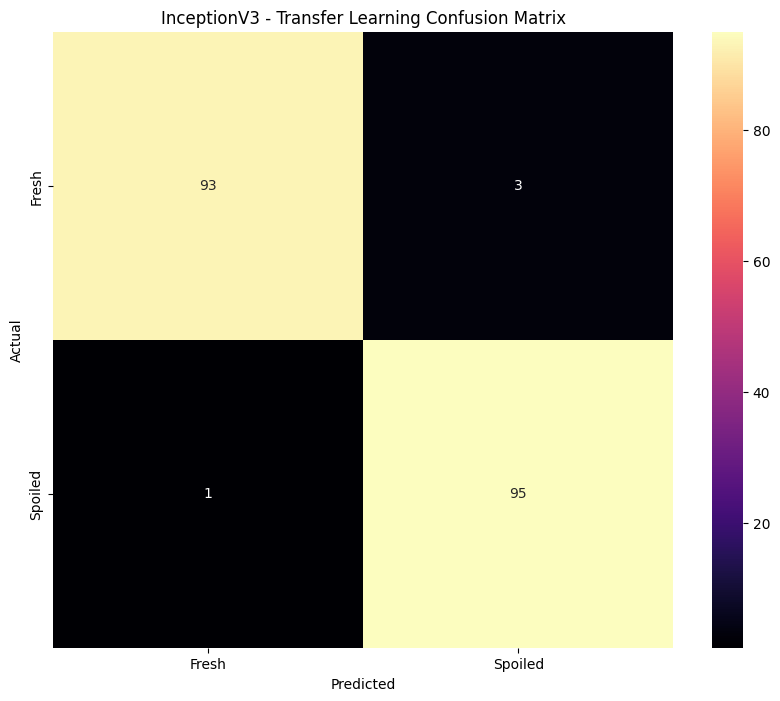


Generating classification report...


Classification Report:

              precision    recall  f1-score   support

       Fresh       0.99      0.97      0.98        96
     Spoiled       0.97      0.99      0.98        96

    accuracy                           0.98       192
   macro avg       0.98      0.98      0.98       192
weighted avg       0.98      0.98      0.98       192



In [13]:
# Evaluation
evaluate_model(inception_model, inception_history_transfer, None, "InceptionV3")

### Model  Performance
The model demonstrates strong generalization, with a high test accuracy showing good generalization to unseen data.

---



### Training & Validation Trends
While the training accuracy steadily improves, the validation accuracy stabilizes around 94%.


---


### Confusion Matrix Analysis
The model has high accuracy, with only 4 misclassifications.


---



### Classification Report Insights
- The precision, recall, and F1-scores are all very high for both classes with minimal false positives or false negatives.
- The overall accuracy shows that the model can classify both Fresh and Spoiled meat with a strong level of reliability.


### MobileNetV2

In [14]:
# Training
mobilenet_model, mobilenet_history_transfer = train_transfer_learning(MobileNetV2, "MobileNetV2")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,431,106 (9.27 MB)

 Trainable params: 172,738 (674.76 KB)

 Non-trainable params: 2,258,368 (8.61 MB)


Starting transfer learning training...

Epoch 1/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 46s 854ms/step - accuracy: 0.4729 - loss: 4.5507 - val_accuracy: 0.5000 - val_loss: 3.8482
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 630ms/step - accuracy: 0.5316 - loss: 4.1733 - val_accuracy: 0.5000 - val_loss: 4.0155
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 624ms/step - accuracy: 0.5821 - loss: 3.9937 - val_accuracy: 0.5000 - val_loss: 4.1085
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 631ms/step - accuracy: 0.5991 - loss: 3.8814 - val_accuracy: 0.5000 - val_loss: 3.9888
Epoch 5/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 630ms/step - accuracy: 0.6161 - loss: 3.8005 - val_accuracy: 0.5000 - val_loss: 3.8187
Epoch 6/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 628ms/step - accuracy: 0.6399 - loss: 3.6645 - val_accuracy: 0.5000 - val_loss: 3.7339
Epoch 7/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 630ms/step - accuracy: 0.6326 - loss: 3.5676 - val_accuracy: 0.5053 - val_loss: 3.5982
Epoch 8/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 630ms/step - a


Evaluating on validation set and test set...

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.5401 - loss: 2.8977
Validation Accuracy: 0.5265 
Validation Loss: 2.9048
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - accuracy: 0.7726 - loss: 2.5204
MobileNetV2 Test Accuracy: 0.5260
Test Loss: 2.8693
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step
True Labels Shape: (192,), Pred Labels Shape: (192,)

Plotting accuracy and loss metrics...



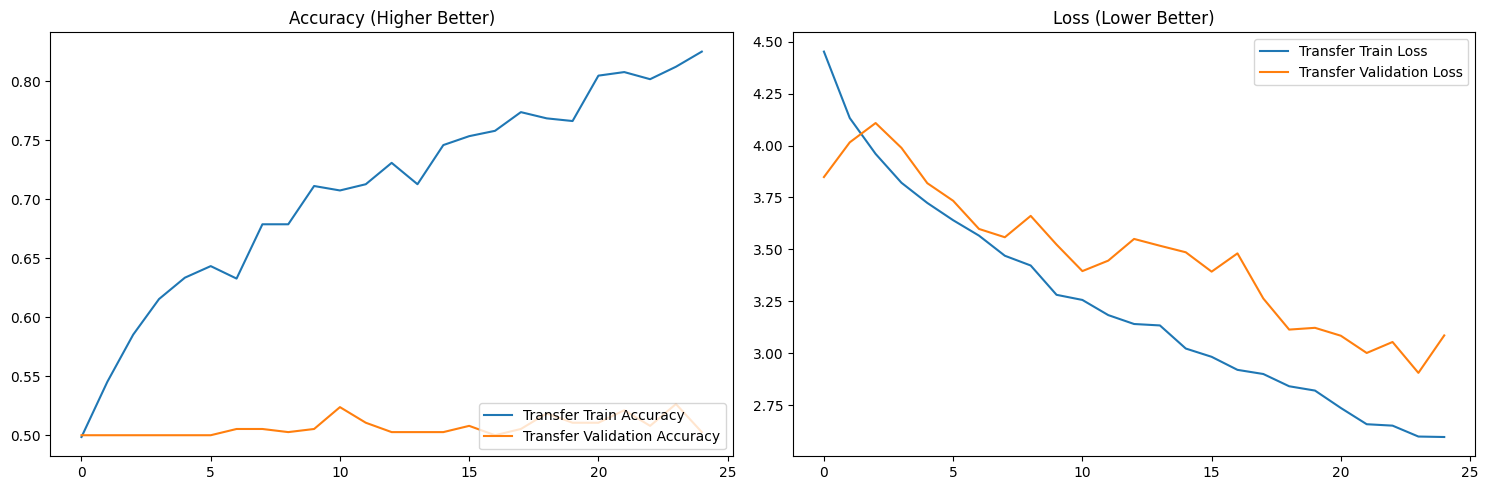


Generating confusion matrix...



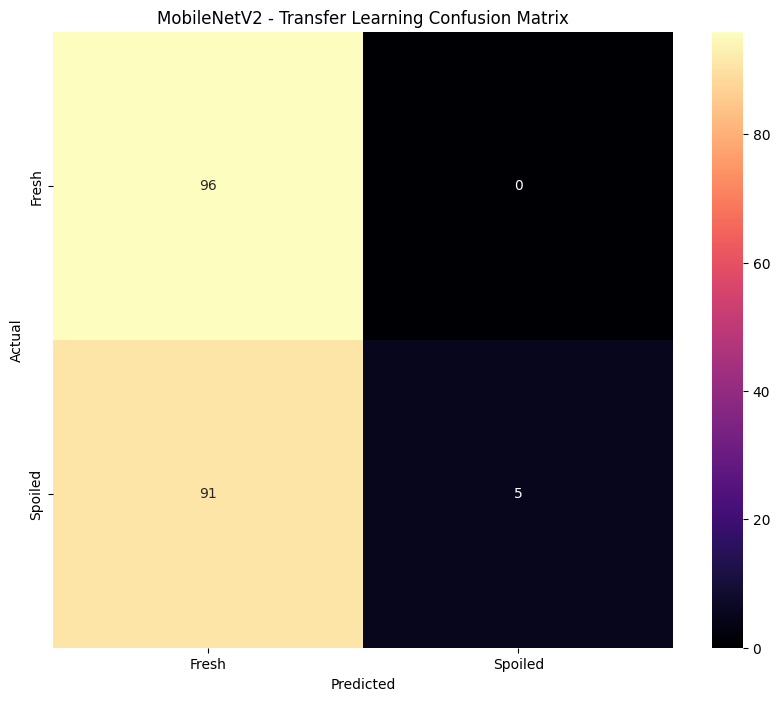


Generating classification report...


Classification Report:

              precision    recall  f1-score   support

       Fresh       0.51      1.00      0.68        96
     Spoiled       1.00      0.05      0.10        96

    accuracy                           0.53       192
   macro avg       0.76      0.53      0.39       192
weighted avg       0.76      0.53      0.39       192



In [15]:
# Evaluation
evaluate_model(mobilenet_model, mobilenet_history_transfer, None, "MobileNetV2")

### Model Performance
The model shows poor performance, with both low accuracy and high loss, indicating that it is struggling to generalize well on the test set.


---



### Training & Validation Trends
The model is overfitting on the training data, showing good learning but failing to generalize effectively to the validation set.


---



### Confusion Matrix Analysis
The model is biased towards predicting the Fresh class and performs poorly on the Spoiled class, indicating a severe class imbalance.

### Classification Report Insights
The model has high precision for the Spoiled class but poor recall and F1-score for Fresh class, leading to imbalanced performance and showing that it fails to predict Spoiled meat correctly most of the time.


### ResNet50

In [16]:
#  Training
resnet_model, resnet_history_transfer = train_transfer_learning(ResNet50, "ResNet50")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,859,138 (91.02 MB)

 Trainable params: 271,042 (1.03 MB)

 Non-trainable params: 23,588,096 (89.98 MB)


Starting transfer learning training...

Epoch 1/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 52s 930ms/step - accuracy: 0.5421 - loss: 4.2553 - val_accuracy: 0.5000 - val_loss: 3.4770
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 641ms/step - accuracy: 0.5050 - loss: 3.7824 - val_accuracy: 0.8730 - val_loss: 3.0887
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 28s 656ms/step - accuracy: 0.5235 - loss: 3.3263 - val_accuracy: 0.5000 - val_loss: 2.7812
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 655ms/step - accuracy: 0.4995 - loss: 3.0582 - val_accuracy: 0.5000 - val_loss: 2.5283
Epoch 5/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 650ms/step - accuracy: 0.4900 - loss: 2.9024 - val_accuracy: 0.5000 - val_loss: 2.3352
Epoch 6/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 649ms/step - accuracy: 0.4738 - loss: 2.6845 - val_accuracy: 0.5000 - val_loss: 2.1538
Epoch 7/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 644ms/step - accuracy: 0.4947 - loss: 2.4379 - val_accuracy: 0.5000 - val_loss: 2.0223
Epoch 8/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 640ms/step - a


Evaluating on validation set and test set...

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.9406 - loss: 1.2477
Validation Accuracy: 0.9339 
Validation Loss: 1.2450
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - accuracy: 0.9616 - loss: 1.2442
ResNet50 Test Accuracy: 0.9583
Test Loss: 1.2444
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step
True Labels Shape: (192,), Pred Labels Shape: (192,)

Plotting accuracy and loss metrics...



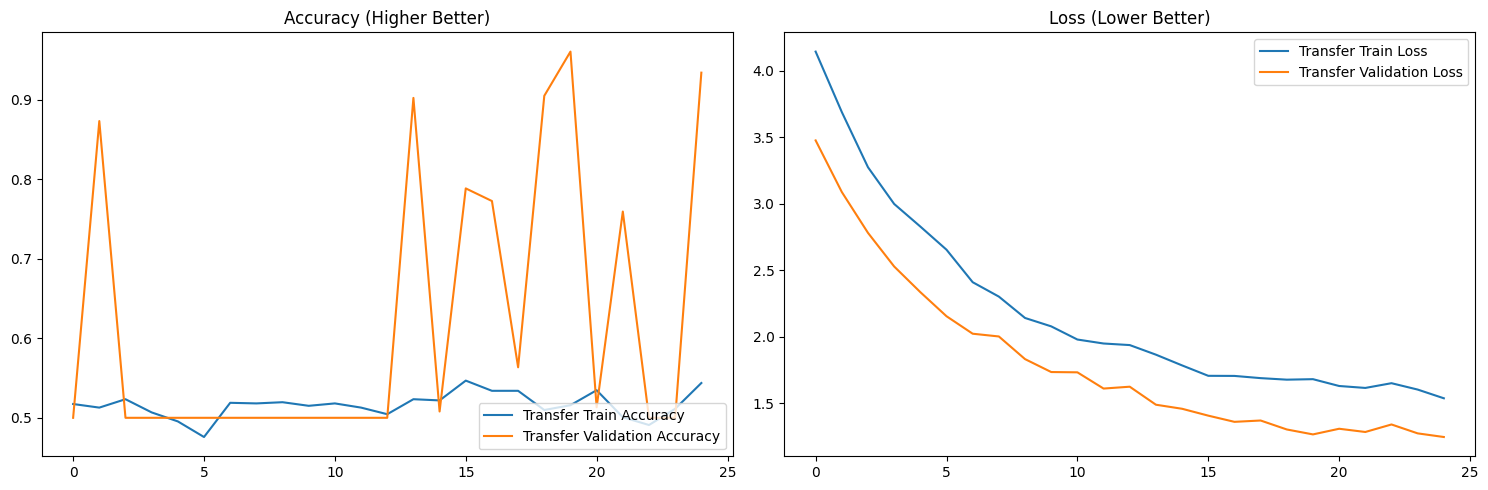


Generating confusion matrix...



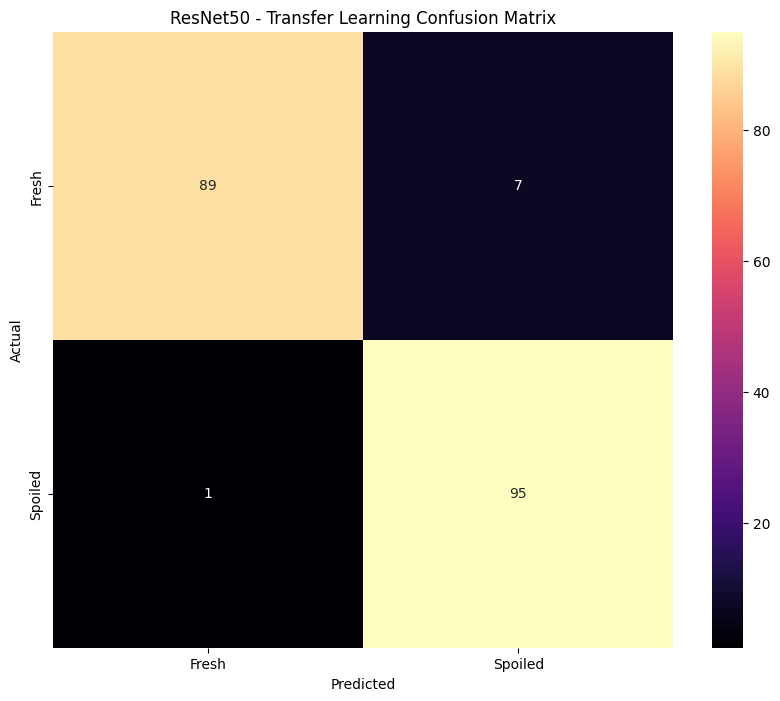


Generating classification report...


Classification Report:

              precision    recall  f1-score   support

       Fresh       0.99      0.93      0.96        96
     Spoiled       0.93      0.99      0.96        96

    accuracy                           0.96       192
   macro avg       0.96      0.96      0.96       192
weighted avg       0.96      0.96      0.96       192



In [17]:
# Evaluation
evaluate_model(resnet_model, resnet_history_transfer, None, "ResNet50")

### Model Performance
The model demonstrates strong generalization, with a high test accuracy and low test loss, showing good generalization to unseen data.


---



### Training & Validation Trends
Training Accuracy consistently improves, reaching close to 1 but there are some fluctuations in validation accuracy.


---



### Confusion Matrix Analysis
The model is performing well overall, with only a few misclassifications.


---



### Classification Report Insights
- The precision, recall, and F1-scores are all very high for both classes with minimal false positives or false negatives.
-The overall accuracy shows that the model can classify both Fresh and Spoiled meat with a strong level of reliability.


### EfficientNetB0

In [18]:
#  Training
efficientnet_model, efficientnet_history_transfer = train_transfer_learning(EfficientNetB0, "EfficientNetB0")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,222,693 (16.11 MB)

 Trainable params: 172,738 (674.76 KB)

 Non-trainable params: 4,049,955 (15.45 MB)


Starting transfer learning training...

Epoch 1/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.4868 - loss: 4.2439 - val_accuracy: 0.5000 - val_loss: 3.7476
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 620ms/step - accuracy: 0.4958 - loss: 4.0905 - val_accuracy: 0.5000 - val_loss: 3.6222
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 648ms/step - accuracy: 0.5098 - loss: 3.9190 - val_accuracy: 0.5000 - val_loss: 3.5197
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 631ms/step - accuracy: 0.5027 - loss: 3.8356 - val_accuracy: 0.5000 - val_loss: 3.4380
Epoch 5/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 635ms/step - accuracy: 0.5088 - loss: 3.7163 - val_accuracy: 0.5000 - val_loss: 3.3652
Epoch 6/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 632ms/step - accuracy: 0.5290 - loss: 3.6254 - val_accuracy: 0.5000 - val_loss: 3.2763
Epoch 7/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 642ms/step - accuracy: 0.4941 - loss: 3.7043 - val_accuracy: 0.5000 - val_loss: 3.2028
Epoch 8/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 634ms/step - accu


Evaluating on validation set and test set...

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.5222 - loss: 2.4206
Validation Accuracy: 0.5000 
Validation Loss: 2.4234
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.2357 - loss: 2.4581
EfficientNetB0 Test Accuracy: 0.5000
Test Loss: 2.4236
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step
True Labels Shape: (192,), Pred Labels Shape: (192,)

Plotting accuracy and loss metrics...



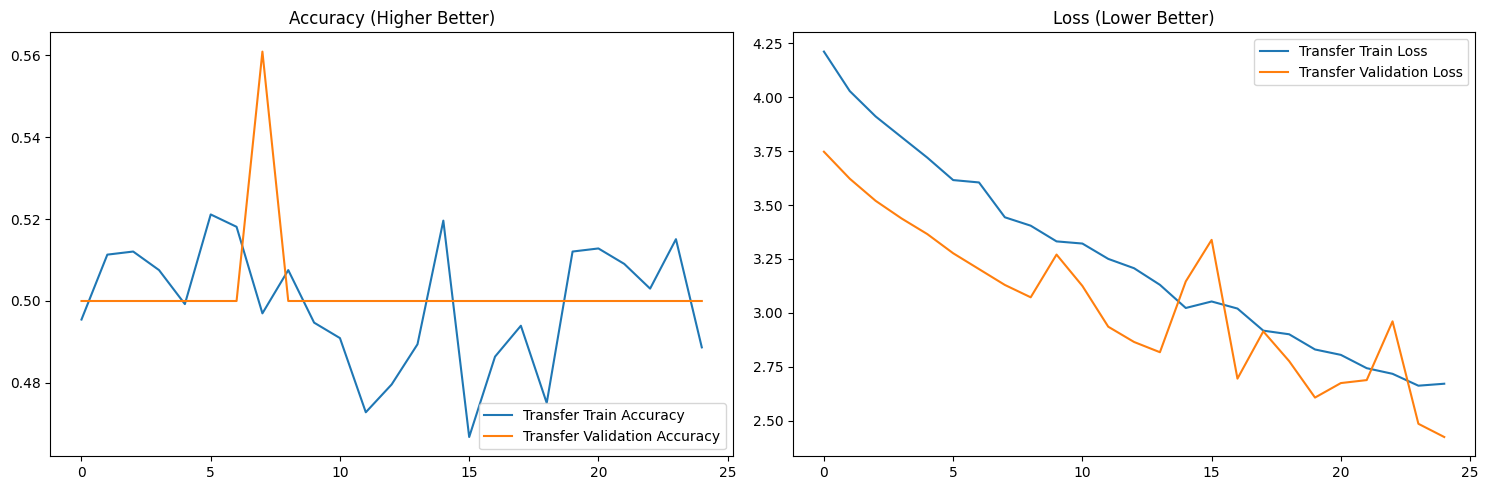


Generating confusion matrix...



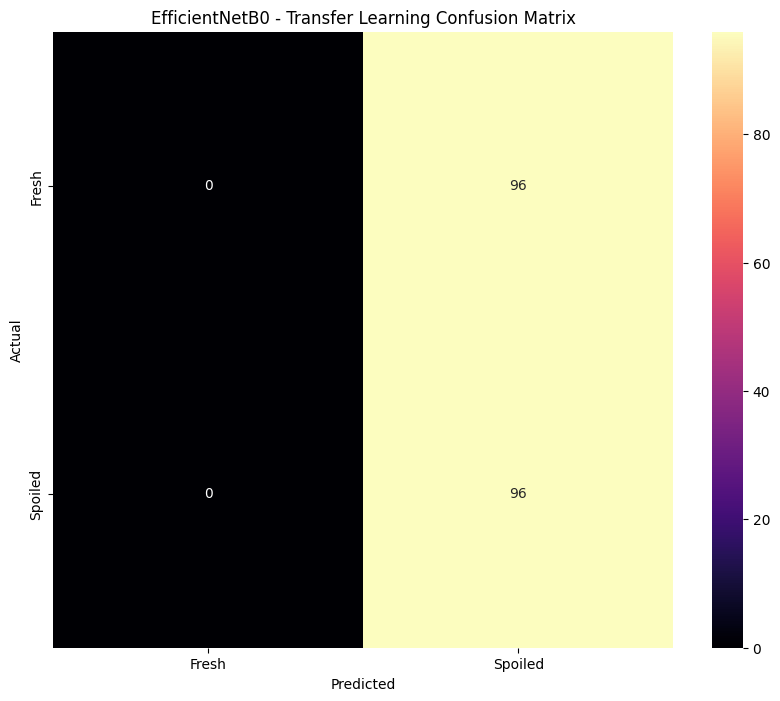


Generating classification report...


Classification Report:

              precision    recall  f1-score   support

       Fresh       0.00      0.00      0.00        96
     Spoiled       0.50      1.00      0.67        96

    accuracy                           0.50       192
   macro avg       0.25      0.50      0.33       192
weighted avg       0.25      0.50      0.33       192



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [19]:
# Evaluation
evaluate_model(efficientnet_model, efficientnet_history_transfer, None, "EfficientNetB0")

### Model Performance
The model shows poor performance, with a low test accuracy and high test loss, suggesting that it struggles to generalize well to unseen data.


---



### Training & Validation Trends
While training accuracy improves, validation accuracy remains stagnant at 50%, suggesting the model is overfitting to the training data and not generalizing well unseen examples.


---



### Confusion Matrix Analysis
The model is biased towards predicting the Fresh class and performs poorly on the Spoiled class, indicating a severe class imbalance.


---



### Classification Report Insights
While precision for the Spoiled class is high (1.00), the recall is alarmingly low (0.05), meaning the model is unable to correctly identify most spoiled meat instances.


### VGG16

In [20]:
#  Training
vgg_model, vgg_history_transfer = train_transfer_learning(VGG16, "VGG16")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          65,6

 Total params: 14,789,506 (56.42 MB)

 Trainable params: 74,434 (290.76 KB)

 Non-trainable params: 14,715,072 (56.13 MB)


Starting transfer learning training...

Epoch 1/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.5045 - loss: 4.0881 - val_accuracy: 0.5000 - val_loss: 3.4712
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 642ms/step - accuracy: 0.5247 - loss: 3.7902 - val_accuracy: 0.5000 - val_loss: 3.3059
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 639ms/step - accuracy: 0.5110 - loss: 3.6071 - val_accuracy: 0.5000 - val_loss: 3.1384
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 640ms/step - accuracy: 0.5032 - loss: 3.4941 - val_accuracy: 0.5000 - val_loss: 2.9873
Epoch 5/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 645ms/step - accuracy: 0.5596 - loss: 3.2606 - val_accuracy: 0.8333 - val_loss: 2.8375
Epoch 6/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 649ms/step - accuracy: 0.5704 - loss: 3.0673 - val_accuracy: 0.9259 - val_loss: 2.7054
Epoch 7/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 639ms/step - accuracy: 0.5980 - loss: 2.9392 - val_accuracy: 0.8360 - val_loss: 2.5906
Epoch 8/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 644ms/step - accu


Evaluating on validation set and test set...

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.9828 - loss: 1.3640
Validation Accuracy: 0.9815 
Validation Loss: 1.3642
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.9751 - loss: 1.3459
VGG16 Test Accuracy: 0.9740
Test Loss: 1.3428
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step
True Labels Shape: (192,), Pred Labels Shape: (192,)

Plotting accuracy and loss metrics...



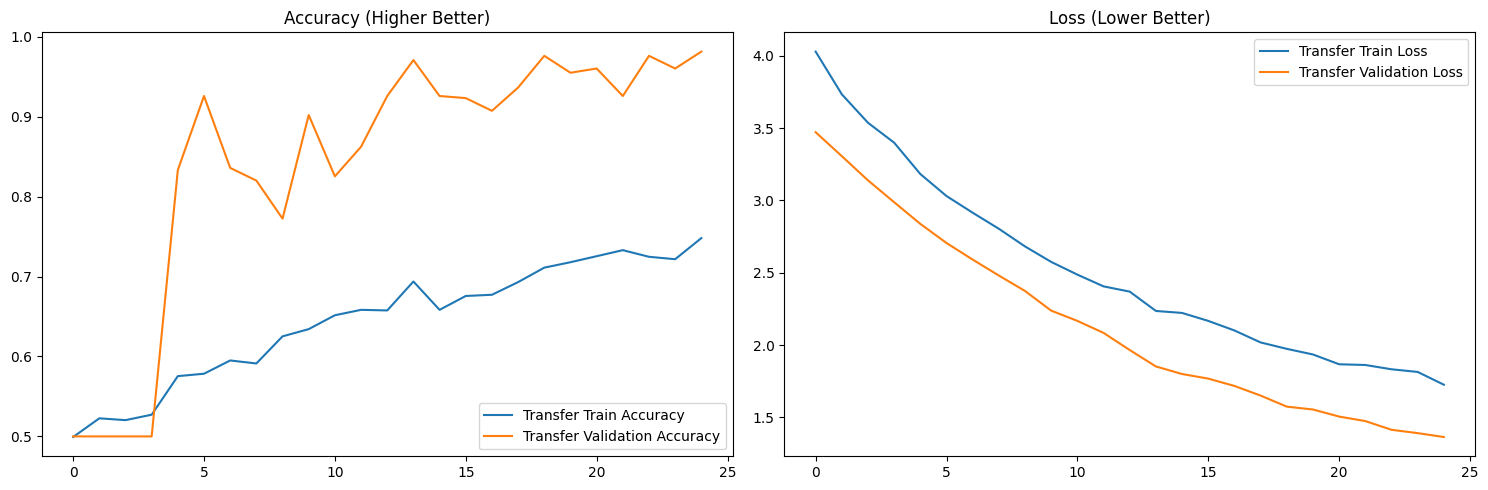


Generating confusion matrix...



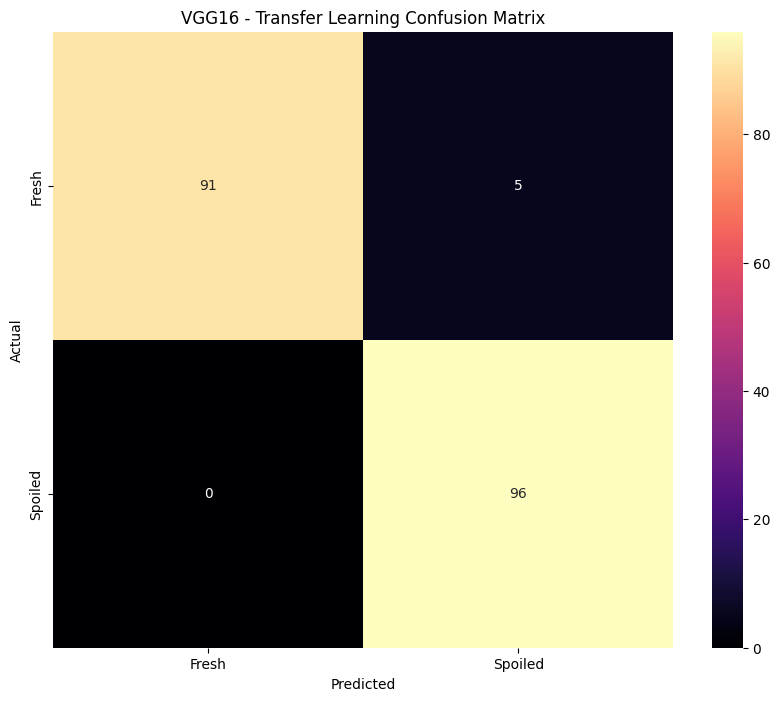


Generating classification report...


Classification Report:

              precision    recall  f1-score   support

       Fresh       1.00      0.95      0.97        96
     Spoiled       0.95      1.00      0.97        96

    accuracy                           0.97       192
   macro avg       0.98      0.97      0.97       192
weighted avg       0.98      0.97      0.97       192



In [21]:
# Evaluation
evaluate_model(vgg_model, vgg_history_transfer, None, "VGG16")

### Model Performance
The model demonstrates strong performance with a high test accuracy and a low test loss, showing good generalization to unseen data.


---



### Training & Validation Trends
The training accuracy improves steadily, while validation accuracy remains high and stabilizes above 98%.



---


### Confusion Matrix Analysis
The model has high accuracy, with only 4 misclassifications.



---


### Classification Report Insights
- The precision, recall, and F1-scores are all very high for both classes with minimal false positives or false negatives.
- The overall accuracy shows that the model can classify both Fresh and Spoiled meat with a strong level of reliability.



### Overall Model Performance

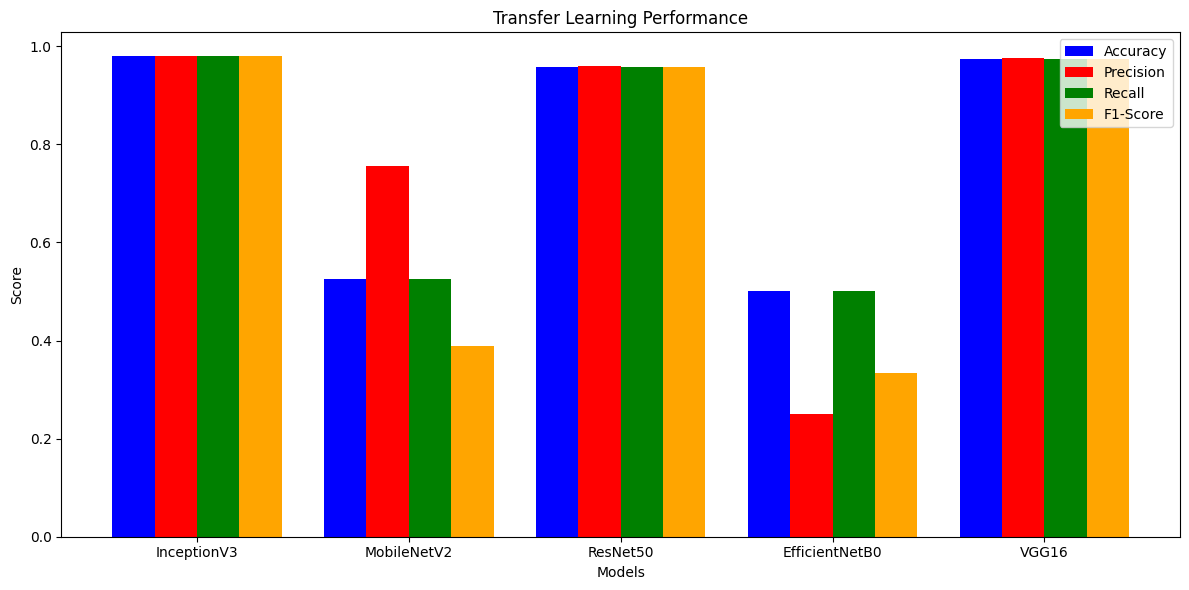

In [22]:
# Plot Transfer Learning Performance for all models
plot_transfer_learning_performance()

## Fine-Tuning

### InceptionV3

In [23]:
# Fine-tuning
inception_model, inception_history_finetune = fine_tune_model("InceptionV3")


Unfreezing last 20 layers for fine-tuning...


Starting fine-tuning training...

Epoch 1/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 55s 965ms/step - accuracy: 0.8564 - loss: 2.9233 - val_accuracy: 0.9550 - val_loss: 2.4831
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 654ms/step - accuracy: 0.8124 - loss: 3.0943 - val_accuracy: 0.9550 - val_loss: 2.4823
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 649ms/step - accuracy: 0.8378 - loss: 2.9694 - val_accuracy: 0.9577 - val_loss: 2.4815
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 28s 670ms/step - accuracy: 0.8181 - loss: 2.9870 - val_accuracy: 0.9497 - val_loss: 2.4801
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 651ms/step - accuracy: 0.8459 - loss: 2.9078 - val_accuracy: 0.9524 - val_loss: 2.4752
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 28s 669ms/step - accuracy: 0.8009 - loss: 2.9721 - val_accuracy: 0.9550 - val_loss: 2.4678
Epoch 7/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 648ms/step - accuracy: 0.8292 - loss: 2.9123 - val_accuracy: 0.9444 - val_loss: 2.4696
Epoch 8/15
42/4


Evaluating on validation set and test set...

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.9478 - loss: 2.4380
Validation Accuracy: 0.9471 
Validation Loss: 2.4348
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.9676 - loss: 2.3527
InceptionV3 Test Accuracy: 0.9583
Test Loss: 2.4053
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step
True Labels Shape: (192,), Pred Labels Shape: (192,)

Plotting accuracy and loss metrics...



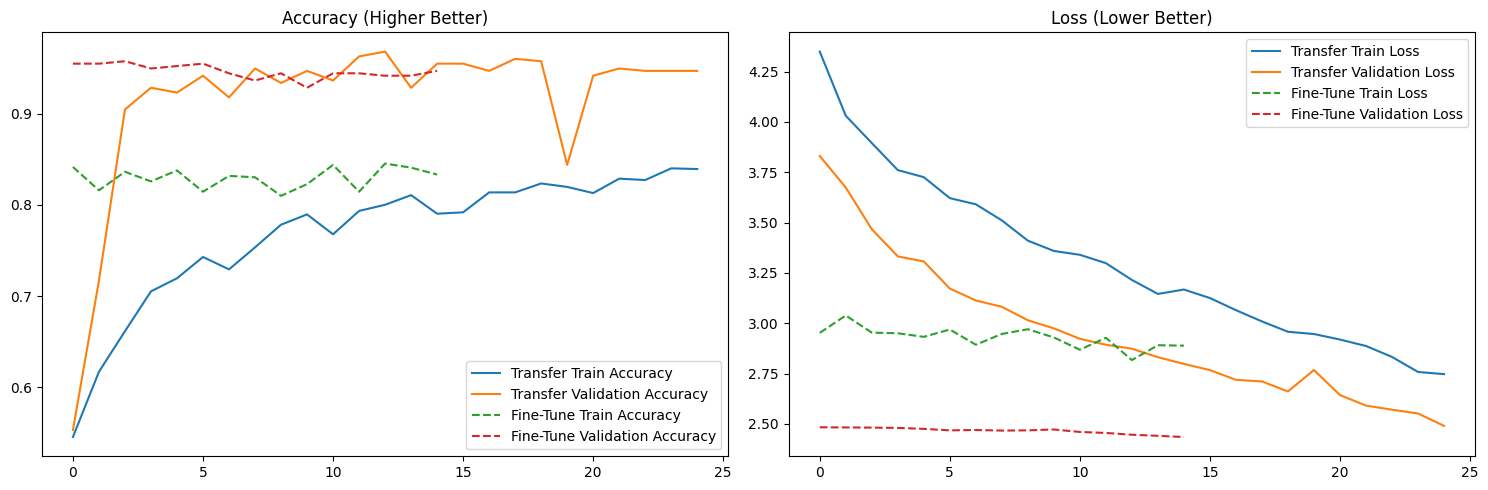


Generating confusion matrix...



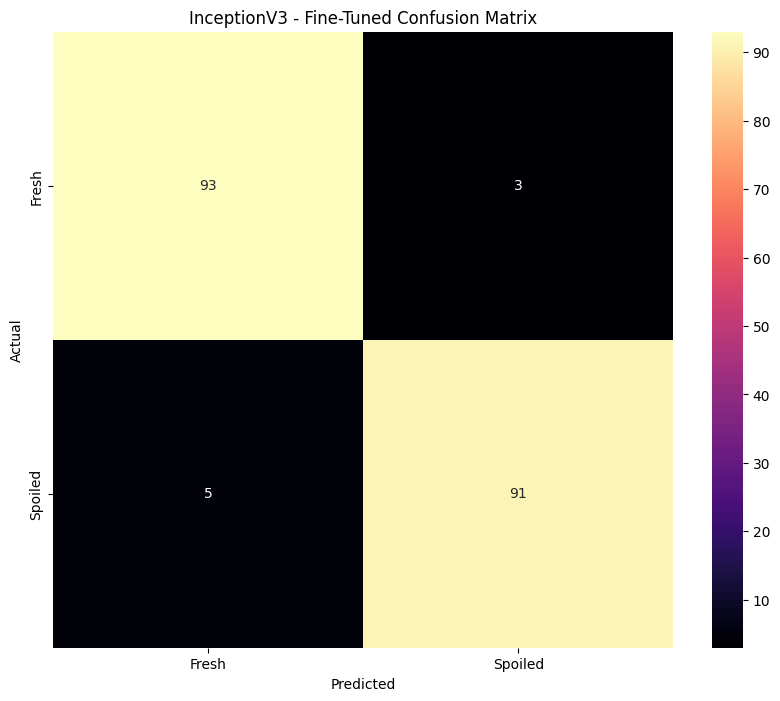


Generating classification report...


Classification Report:

              precision    recall  f1-score   support

       Fresh       0.95      0.97      0.96        96
     Spoiled       0.97      0.95      0.96        96

    accuracy                           0.96       192
   macro avg       0.96      0.96      0.96       192
weighted avg       0.96      0.96      0.96       192



In [24]:
# Evaluation
evaluate_model(inception_model, inception_history_transfer, inception_history_finetune, "InceptionV3", "Fine-Tuned")

### Model  Performance
The model demonstrates strong generalization, with a high test accuracy showing good generalization to unseen data.

---



### Training & Validation Trends
Validation accuracy is higher than training accuracy


---


### Confusion Matrix Analysis
The model is performing well overall, with only a few misclassifications


---



### Classification Report Insights
- The precision, recall, and F1-scores are all very high for both classes with minimal false positives or false negatives.
- The overall accuracy shows that the model can classify both Fresh and Spoiled meat with a strong level of reliability.


### ResNet50

In [26]:
# Fine-tuning
resnet_model, resnet_history_finetune = fine_tune_model("ResNet50")


Unfreezing last 20 layers for fine-tuning...


Starting fine-tuning training...

Epoch 1/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 50s 868ms/step - accuracy: 0.5404 - loss: 2.0350 - val_accuracy: 0.5000 - val_loss: 1.4031
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 644ms/step - accuracy: 0.5422 - loss: 1.9707 - val_accuracy: 0.7698 - val_loss: 1.3248
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 642ms/step - accuracy: 0.5306 - loss: 1.9799 - val_accuracy: 0.5000 - val_loss: 1.4347
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 637ms/step - accuracy: 0.5344 - loss: 1.9508 - val_accuracy: 0.5000 - val_loss: 1.3883
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 644ms/step - accuracy: 0.4937 - loss: 2.0600 - val_accuracy: 0.5000 - val_loss: 1.3468
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 26s 633ms/step - accuracy: 0.5039 - loss: 2.0409 - val_accuracy: 0.5423 - val_loss: 1.3349
Epoch 7/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 633ms/step - accuracy: 0.4977 - loss: 2.0091 - val_accuracy: 0.5053 - val_loss: 1.3294
Epoch 8/15
42/4


Evaluating on validation set and test set...

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.7616 - loss: 1.3295
Validation Accuracy: 0.7698 
Validation Loss: 1.3248
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - accuracy: 0.8500 - loss: 1.3070
ResNet50 Test Accuracy: 0.7500
Test Loss: 1.3292
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step
True Labels Shape: (192,), Pred Labels Shape: (192,)

Plotting accuracy and loss metrics...



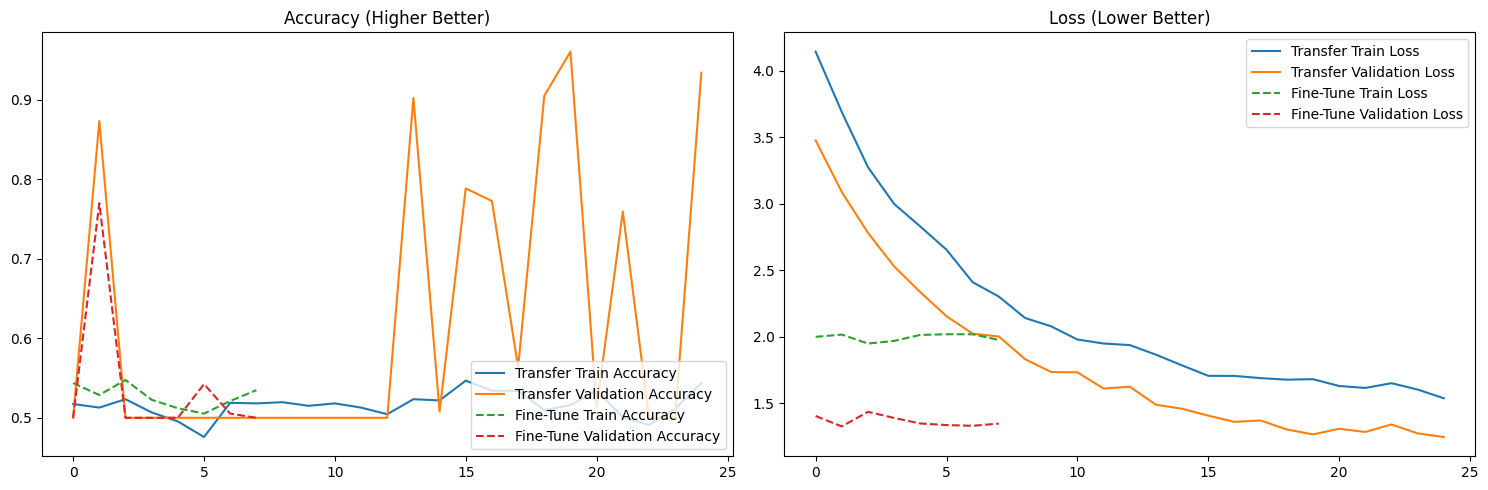


Generating confusion matrix...



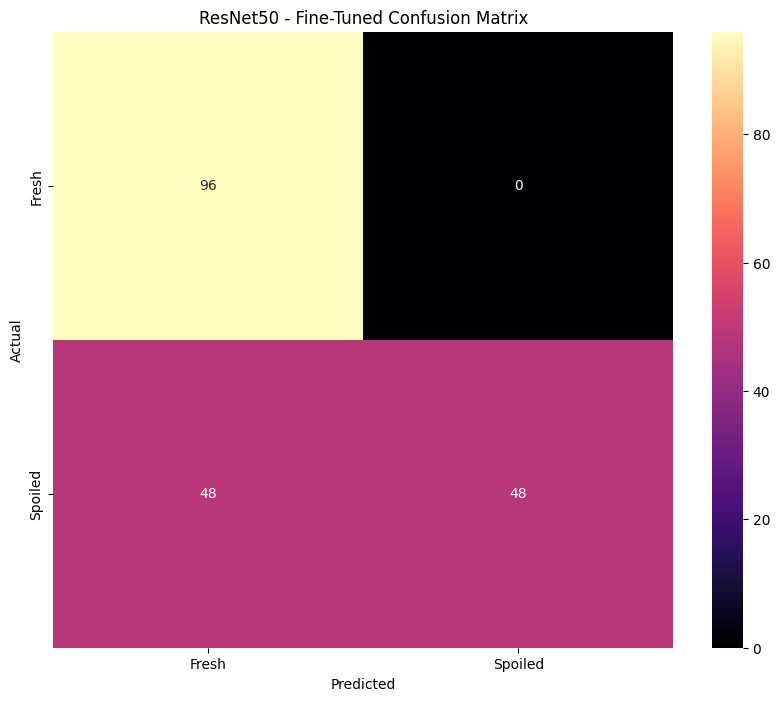


Generating classification report...


Classification Report:

              precision    recall  f1-score   support

       Fresh       0.67      1.00      0.80        96
     Spoiled       1.00      0.50      0.67        96

    accuracy                           0.75       192
   macro avg       0.83      0.75      0.73       192
weighted avg       0.83      0.75      0.73       192



In [27]:
# Evaluation
evaluate_model(resnet_model, resnet_history_transfer, resnet_history_finetune, "ResNet50", "Fine-Tuned")

### Model  Performance
- The model demonstrates moderate performance. While the validation accuracy is slightly higher, the test accuracy suggests some challenges in generalizing to unseen data.
- The test loss is also slightly higher than the validation loss.

---



### Training & Validation Trends
- The gap between the validation accuracy and training accuracy is small, suggesting that the model is not overfitting significantly.
- However, the validation loss is slightly higher than the training loss which indicates some minor generalization issues.


---


### Confusion Matrix Analysis
The confusion matrix reveals that the model performs well in classifying "Fresh" meat but struggles with "Spoiled" meat.

---



### Classification Report Insights
- The classification report shows that the model has high precision and recall for "Fresh" meat, but lower precision and recallfor "Spoiled" meat.
- The overall accuracy suggests that the model can classify meat with moderate reliability but requires improvement, particularly for the "Spoiled" class.


### VGG16

In [28]:
# Fine-tuning
vgg_model, vgg_history_finetune = fine_tune_model("VGG16")


Unfreezing last 20 layers for fine-tuning...


Starting fine-tuning training...

Epoch 1/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 58s 914ms/step - accuracy: 0.7894 - loss: 1.8982 - val_accuracy: 0.9365 - val_loss: 1.3048
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 28s 657ms/step - accuracy: 0.8438 - loss: 1.7222 - val_accuracy: 0.9312 - val_loss: 1.3442
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 28s 654ms/step - accuracy: 0.8816 - loss: 1.5731 - val_accuracy: 0.9603 - val_loss: 1.2404
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 649ms/step - accuracy: 0.9003 - loss: 1.5203 - val_accuracy: 0.9471 - val_loss: 1.2526
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 28s 650ms/step - accuracy: 0.9054 - loss: 1.4929 - val_accuracy: 0.9471 - val_loss: 1.2542
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 28s 660ms/step - accuracy: 0.9405 - loss: 1.4218 - val_accuracy: 0.9312 - val_loss: 1.2798
Epoch 7/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 28s 659ms/step - accuracy: 0.9187 - loss: 1.4594 - val_accuracy: 0.9683 - val_loss: 1.2342
Epoch 8/15
42/4


Evaluating on validation set and test set...

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.9926 - loss: 1.2155
Validation Accuracy: 0.9947 
Validation Loss: 1.2220
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - accuracy: 0.9900 - loss: 1.1997
VGG16 Test Accuracy: 0.9896
Test Loss: 1.2056
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step
True Labels Shape: (192,), Pred Labels Shape: (192,)

Plotting accuracy and loss metrics...



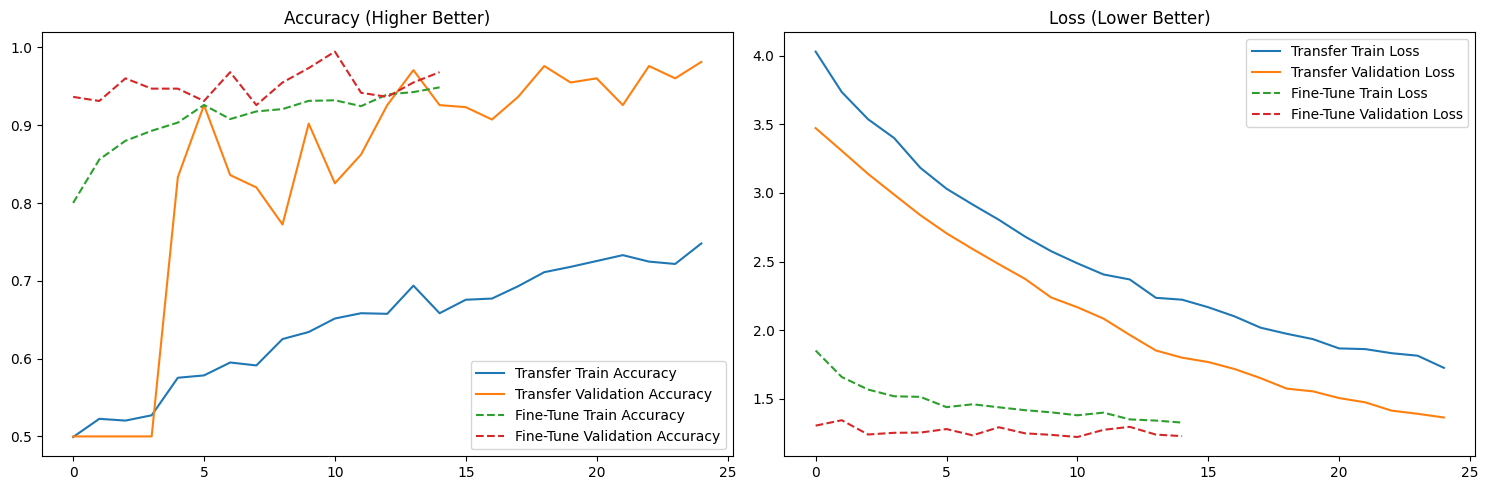


Generating confusion matrix...



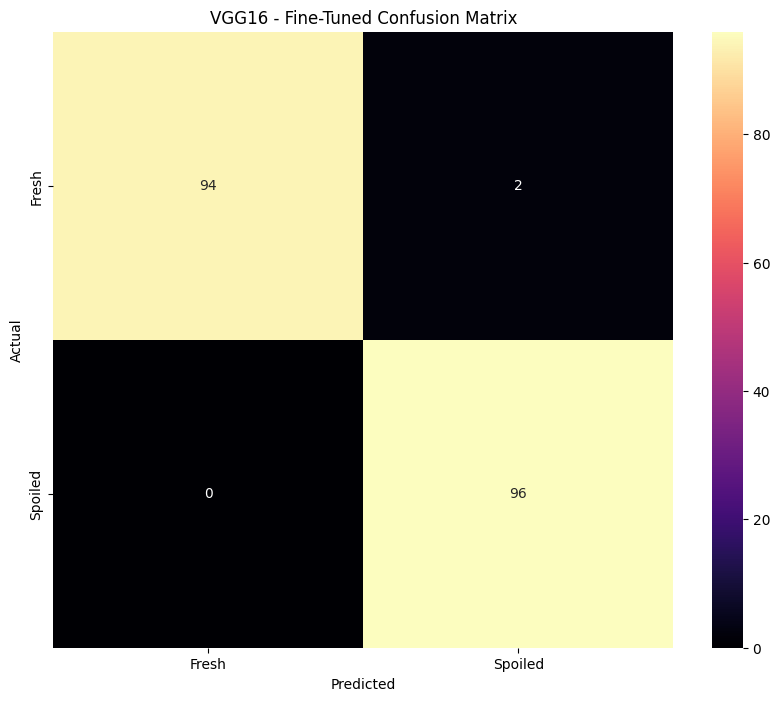


Generating classification report...


Classification Report:

              precision    recall  f1-score   support

       Fresh       1.00      0.98      0.99        96
     Spoiled       0.98      1.00      0.99        96

    accuracy                           0.99       192
   macro avg       0.99      0.99      0.99       192
weighted avg       0.99      0.99      0.99       192



In [29]:
# Evaluation
evaluate_model(vgg_model, vgg_history_transfer, vgg_history_finetune, "VGG16", "Fine-Tuned")

### Model  Performance
The model demonstrates strong generalization, with a high test accuracy showing good generalization to unseen data.

---



### Training & Validation Trends
The gap between the alidation accuracy and training accuracy is small.


---


### Confusion Matrix Analysis
The model has high accuracy, with only 2 misclassifications


---



### Classification Report Insights
The precision, recall, and F1-scores are all very high for both classes with minimal false positives or false negatives. The overall accuracy shows that the model can classify both Fresh and Spoiled meat with a strong level of reliability.


### Overall Model Performance

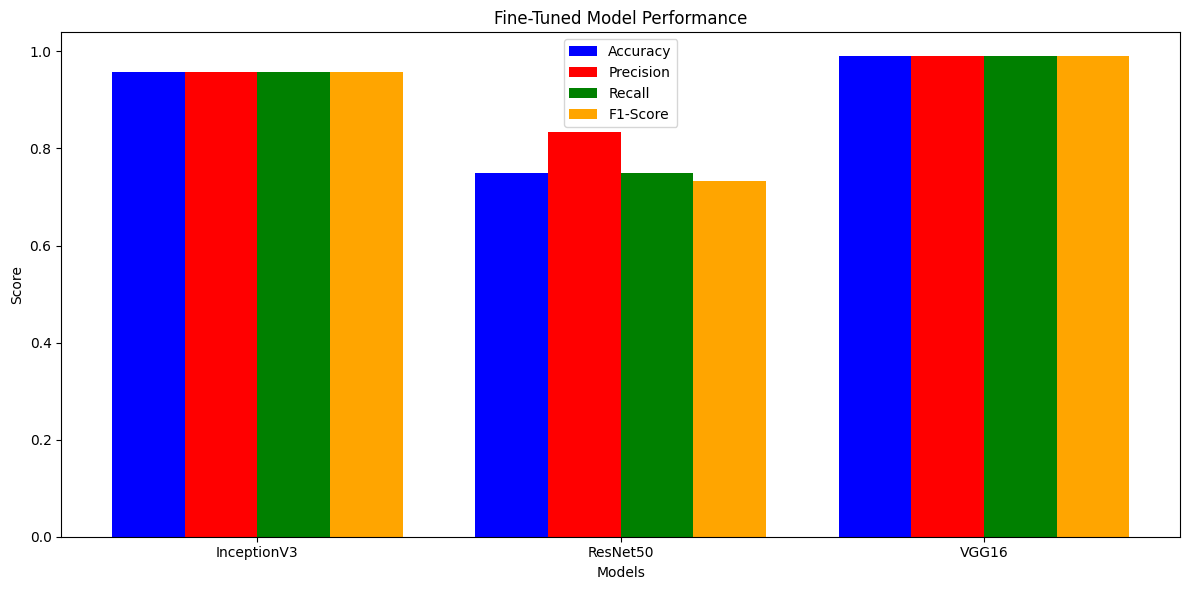

In [30]:
# Plot Fine-Tuning Performance
plot_fine_tuning_performance(["InceptionV3", "ResNet50", "VGG16"])

## Saving the best model

In [31]:
best_model_name = "VGG16_fine_tuned_model.keras"

In [32]:
# Load model
model = tf.keras.models.load_model(best_model_name)

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted TFLite model
with open("meat_classifier.tflite", "wb") as f:
    f.write(tflite_model)

print(f"Best model converted to TFLite successfully!")

Saved artifact at '/tmp/tmpivfqsrlh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132058202664272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132058202660816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132058202663504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132058191480208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132058191479632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132058191480976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132058191479056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132058191481744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132058191481168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132058191482512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1320581914819

## Saving the sceond best model (just in case)

In [33]:
second_best_model_name = "InceptionV3_fine_tuned_model.keras"

In [34]:
# Load model
model = tf.keras.models.load_model(second_best_model_name)

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted TFLite model
with open("second_meat_classifier.tflite", "wb") as f:
    f.write(tflite_model)

print(f"Second best model converted to TFLite successfully!")

Saved artifact at '/tmp/tmp46y4tjig'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132058037399248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132058037399440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132058037400592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132058037400784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132058037401744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132058037399824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132058037402128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132058037402320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132058037403280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132058037402512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132058037400976